In [15]:
%matplotlib inline

In [16]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import tools                           # A few helpers to plot multiple images
from PIL import Image                  # For rescaling images
from ipywidgets import interact, fixed # Interact with images
from scipy.spatial import distance     # To compute euclidian distance
import pandas as pd

In [17]:
img_link = 'images/sudoku_1.png'

annotation_link = 'annotations/sudoku_1.txt'

In [18]:
data = pd.read_csv(annotation_link, header=None)

x1_annot = []
y1_annot = []
x2_annot = []
y2_annot = []

img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)
height, width = img.shape[:2]

H=height

for _, row in data.iterrows():
    x1_annot.append(int(row[0]))
    y1_annot.append(int(row[1]))
    x2_annot.append(int(row[2]))
    y2_annot.append(int(row[3]))

print(x1_annot,y1_annot,H)
    
number_lines = len(row)


[478, 95, 500, 111, 504, 110] [975, 948, 424, 427, 353, 363] 1376


## Prefiltering

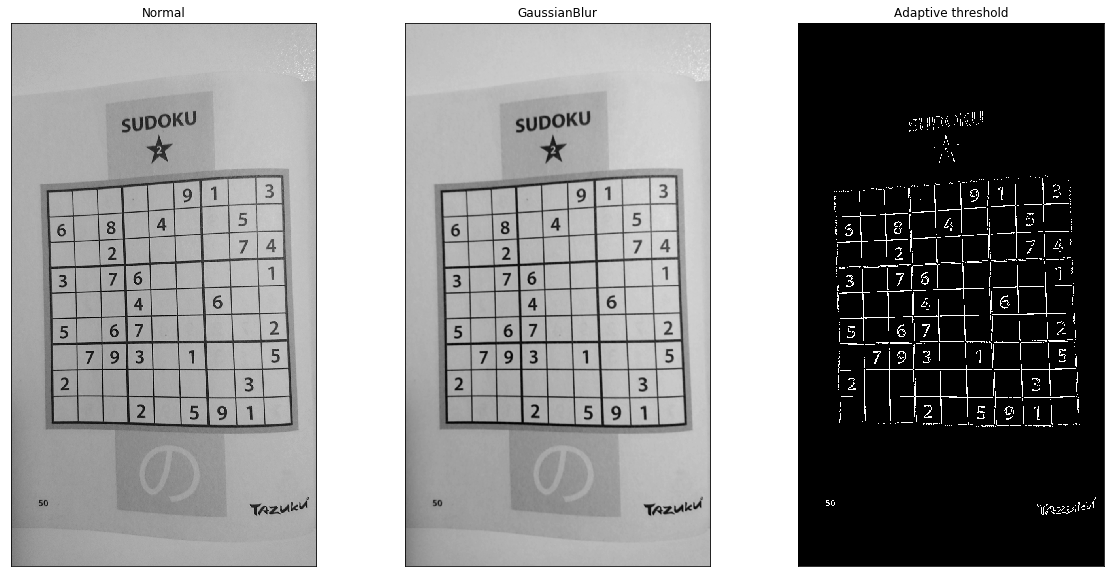

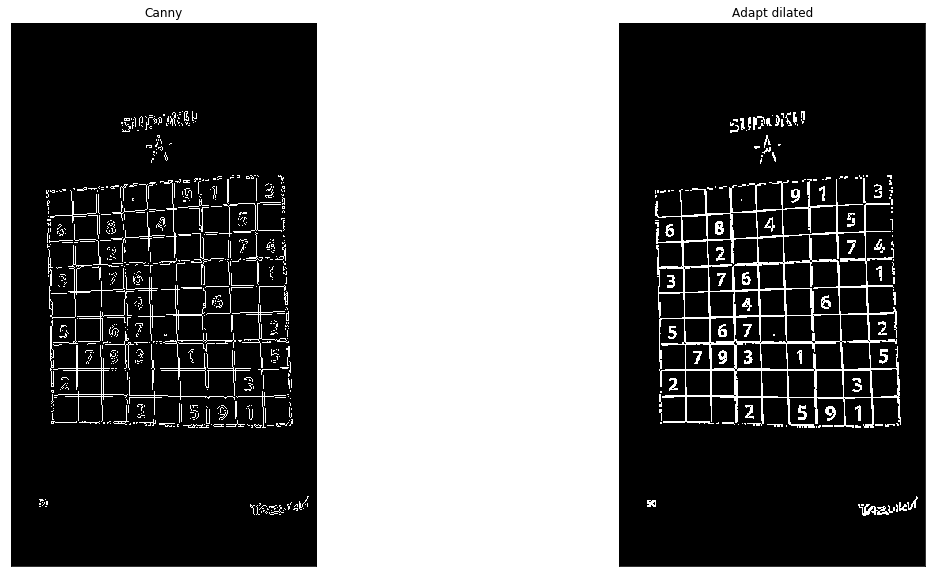

In [22]:
# prefiltrering and scaling 

img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(img_link, cv2.IMREAD_COLOR)

b,g,r = cv2.split(img_color)
img_color = cv2.merge( [r,g,b])

iGausKernelSize = 5
imgFilt = cv2.GaussianBlur(img, (iGausKernelSize, iGausKernelSize), 0)

imgThresh = cv2.adaptiveThreshold(imgFilt, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV, 3, 5)


iReducFactor = 2
iStart = iReducFactor // 2
imgReduc = imgThresh[iStart::iReducFactor, iStart::iReducFactor]
   
# compute the median of the single channel pixel intensities
med = np.median(imgReduc)
 
# apply automatic Canny edge detection using the computed median
sigma = 0.3
loThreshold = int( max( 0, (1.0 - sigma) * med))
hiThreshold = int( min( 255, (1.0 + sigma) * med))

edges = cv2.Canny(imgReduc, loThreshold, hiThreshold, apertureSize=3, L2gradient=False)
edges_dilated = cv2.dilate(imgReduc, np.ones((2,2), dtype=np.uint8))

#cv2.imwrite('sudoku_gb.png', imgFilt)
#cv2.imwrite('sudoku_at.png', imgThresh)
#cv2.imwrite('sudoku_edges.png', edges)
#cv2.imwrite('sudoku_dilated.png', edges_dilated)

# plot all the images
tools.multiPlot( 1, 3, (img, imgFilt, imgThresh,),
                       ('Normal', 'GaussianBlur', 'Adaptive threshold',),
                        cmap_tuple=(cm.gray, cm.gray, cm.gray,))

tools.multiPlot(1, 2, (edges, edges_dilated), ('Canny', 'Adapt dilated'), cmap_tuple=(cm.gray, cm.gray))

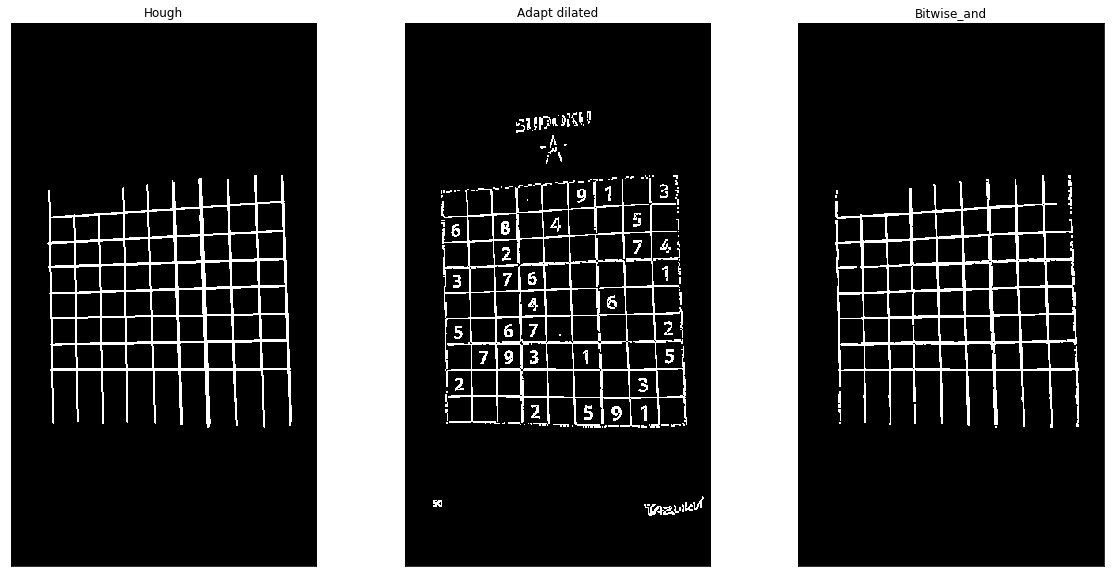

In [23]:
height, width = img.shape[:2]
mat = np.zeros((height,width))

minLineLength = 250
maxLineGap = 20

lines = cv2.HoughLinesP(edges_dilated,1,np.pi/180,100,np.array([]),minLineLength,maxLineGap)
#print(lines)
#print(len(lines))
for l in lines:
    for x1,y1,x2,y2 in l:
        cv2.line(mat,(2*x1,2*y1),(2*x2,2*y2),(255, 255, 255),3)
        cv2.line(img_color,(2*x1,2*y1),(2*x2,2*y2),(255,0,0),3)

iReducFactor = 2
iStart = iReducFactor // 2
blackReduc = mat[iStart::iReducFactor, iStart::iReducFactor]


blackReduc = blackReduc.astype('uint8')

img_and = cv2.bitwise_and(blackReduc, edges_dilated)

dilated = cv2.dilate(img_and, np.ones((2,2), dtype=np.uint8))

#cv2.imwrite('sudoku_hough.png', mat)
#cv2.imwrite('sudoku_bw.png', dilated)

#test=cv2.countNonZero(dilated)

#print(test)

tools.multiPlot(1, 3, (mat, edges_dilated, dilated,), ('Hough', 'Adapt dilated', 'Bitwise_and',),\
                cmap_tuple=(cm.gray, cm.gray, cm.gray,))

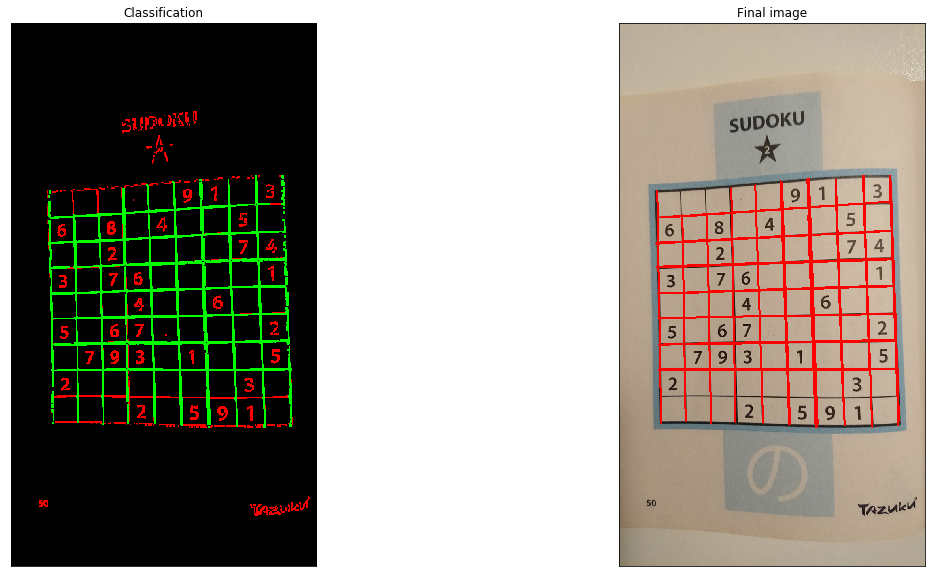

In [24]:
colored = np.zeros((dilated.shape[0], dilated.shape[1], 3), dtype='uint8')

colored[:,:,0] = edges_dilated
colored[:,:,0] -= dilated
colored[:,:,1] = dilated

#cv2.imwrite('sudoku_class.png', cv2.cvtColor(colored, cv2.COLOR_RGB2BGR))
#cv2.imwrite('sudoku_final.png', cv2.cvtColor(img_color, cv2.COLOR_RGB2BGR))

tools.multiPlot(1, 2, (colored, img_color), ('Classification', 'Final image',), cmap_tuple=(cm.gray, cm.gray,))

Pourcent of true positive pixels =  0.5533980582524272 %
Pourcent of false positive pixels =  99.44660194174757 %
0 over 30 lines have been correctly detected


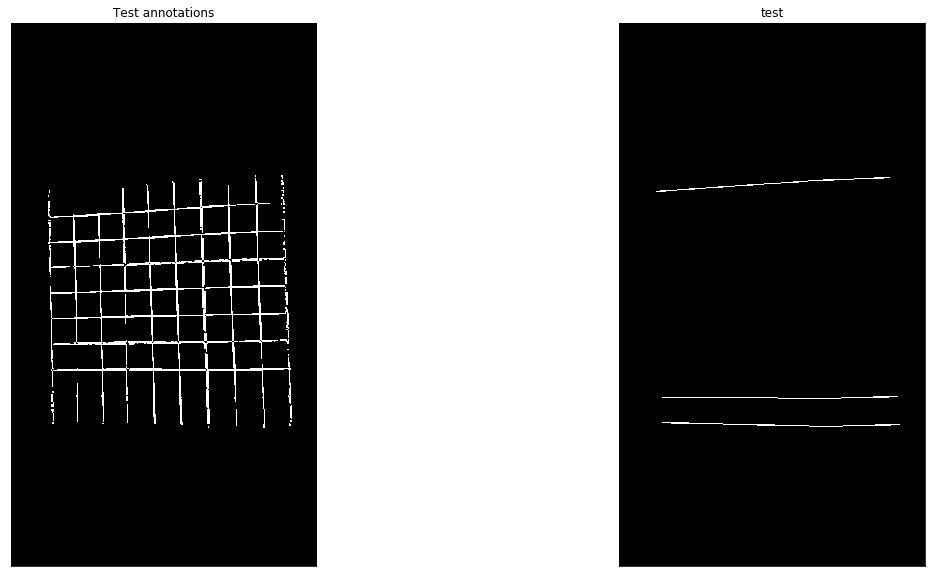

In [26]:
#height, width = img.shape[:2]
mat_annotations1 = np.zeros((height,width))

img_color = cv2.imread(img_link, cv2.IMREAD_COLOR)

b,g,r = cv2.split(img_color)
img_color = cv2.merge( [r,g,b])


#lines_annotations = lines#output of the annotations (expect a vector containing x1,y1,x2,y2 the coordinates of the vector ends)
for i in range(len(x1_annot)):
    cv2.line(mat_annotations1,(int(x1_annot[i]),H-int(y1_annot[i])),(int(x2_annot[i]),H-int(y2_annot[i])),(255, 255, 255),2) #peut-etre changer le 2*
    #cv2.line(img_color,(2*x1,2*y1),(2*x2,2*y2),(255,0,0),3) 

        
#Comparison between adaptive threshold and annotations
        
iReducFactor = 2
iStart = iReducFactor // 2
blackReduc_annotations = mat_annotations1[iStart::iReducFactor, iStart::iReducFactor]

blackReduc_annotations = blackReduc_annotations.astype('uint8') #photo noire contenant toutes les droites tracees dans les annotations

blackReduc_annotations_invert = (255-blackReduc_annotations)

true_positive = cv2.bitwise_and(img_and, blackReduc_annotations)

false_positive = cv2.bitwise_and(img_and, blackReduc_annotations_invert)

num_pixels_detected = cv2.countNonZero(img_and)

num_true_positive = cv2.countNonZero(true_positive)

num_false_positive = cv2.countNonZero(false_positive)

pourcent_true = num_true_positive/num_pixels_detected

pourcent_false = num_false_positive/num_pixels_detected

print("Pourcent of true positive pixels = ", pourcent_true*100, "%")
print("Pourcent of false positive pixels = ", pourcent_false*100, "%")

#Comparison between Hough and annotations

good_lines_detected = 0
i=0
for i in range(len(x1_annot)):
    mat_annotations = np.zeros((height,width))
    cv2.line(mat_annotations,(int(x1_annot[i]),H-int(y1_annot[i])),(int(x2_annot[i]),H-int(y2_annot[i])),(255, 255, 255),2)
    pixels_annotations=cv2.countNonZero(mat_annotations)
    for ll in lines :
        mat = np.zeros((height,width))
        for x11,y11,x22,y22 in ll: 
            cv2.line(mat,(2*x11,2*y11),(2*x22,2*y22),(255, 255, 255),3)
            pixels_Hough=cv2.countNonZero(mat)
            num_pixels_in_common = cv2.countNonZero(cv2.bitwise_and(mat_annotations1, mat))
            #if num_pixels_in_common > 2000 :
            #    print(num_pixels_in_common,i)
            #    i=i+1
            if 0.95*distance.euclidean((x1,y1), (x2,y2)) < distance.euclidean((x11,y11), (x22,y22)) < 1.05*distance.euclidean((x1,y1), (x2,y2)) and (num_pixels_in_common > 0.8*pixels_Hough or num_pixels_in_common > 0.8*pixels_annotations ): 
                good_lines_detected = good_lines_detected + 1

print(good_lines_detected, "over", len(lines), "lines have been correctly detected")   

tools.multiPlot(1, 2, (img_and,mat_annotations1),
                        ('Test annotations','test'),
                        cmap_tuple=(cm.gray,cm.gray))